<a href="https://colab.research.google.com/github/joshstruggles/Local-Area-Unemployment-Statistics-California/blob/main/Time_Series_Analysis_of_LAUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To-Do List


- ~~We are getting random results on our RNN model due to the way Keras randomizes Numpy. We will need to figure out how to create a random_state for the functioned models~~
- ~~Verify model performance~~
  - ~~Equalize test data pool size for all models~~
  - ~~if we are incorrect we will need to change models/predict on new models:~~
    - ~~The only exception is Monterey County, the RNN model has a test score 0.0001% better than the ARIMA model~~
- Attempt boosting RNN performance (we may not be able to keep function for RNN and may need to consider a gridsearch function).

- Predict values on models with best performance
  - We are looking for 12 months of predictions after March 2023 to say that there will still indeed be perceivable seasonality in rate of unemployment
- Finish Markdown portions

- Finish comments on all cells

- Figure out how to hardcode visuals into google slides

- Include section on ways the data is incomplete:
  - Updated ag worker numbers for example

- Fix visualizations in notebook

## Dataset

__['Local Area Unemployment Statistics'](https://data.ca.gov/dataset/local-area-unemployment-statistics-laus)__  current as of March, 2023. <br>

## Business Problem

According to a recent article posted on what could be considered America's most uncelebrated holiday __['National Skilled Trades Day'](https://gvwire.com/2023/05/02/on-national-skilled-trades-day-americas-labor-shortage-looms/)__, there is a high need for skilled labor in the job market. Specifically, these are blue collar jobs in the trades (carpentry, HVAC, iron work, sheet metal, and aviation). There is a growing sentiment in the United States that there aren't people willing to work, but according to the article by Elen  Theodossiou and Steven F. Hipple, __['Unemployment remains high in 2010'](https://www.bls.gov/opub/mlr/2011/03/art1full.pdf)__, __"Workers with less education continued to experience a substantially higher unemployment rate than did better educated members of the labor force."__(4)
<br>

Taking into consideration that ALL the jobs highlighted in the article __['National Skilled Trades Day'](https://gvwire.com/2023/05/02/on-national-skilled-trades-day-americas-labor-shortage-looms/)__ require some kind of certificate of completion from a trade school or on the job training, it is our intention to look at counties in California with high unemployment rates and attempt to identify members of specific business sectors that the EDD (State of California Employment Development Department) can recruit for training in these high demand jobs.
<br>

Are there then groups in our data on counties and unemployment rate that may shed light on a potential group of candidates for a proposal for an EDD sponsored version of job training? That is the goal of our project.

## Method of Analysis/ Time Series Analysis of California's Unemployment Rate

Now that we have determined that there is a relationship between higher rates of unemployment and education we will look to determine a predictive model on the time series data we have for the top five crop producing counties in California and determine when the highest rate of unemployment (seasonality) occurs for each county and determine when a potential educational program could be implemented. <br>

With this data we can carefully craft the skeleton of a 6-month educational program and through the published opinions of local experts and government entities begin looking at potential fields of study/educational partners to reach out to in order to create a specialized educational program. <br>

Ultimately, the reason for making these suggestions is to help improve the __[living conditions](https://www.hcd.ca.gov/planning-and-community-development/housing-elements/building-blocks/farmworkers)__ and occupational opportunities of skilled laborers in the agricultural field. <br>

### College Educational Programs and Community College opportunties for trades and beyond

The reason for proposing trade school opportunities primarily is that there is a significantly smaller amount of __[training to deployment](https://toptrade.school/how-long-does-trade-school-take/)__ than traditional four year schools, something to the tune of 6 months to a year for a full time student. Since our proposal is for off-season migrant and farm workers who would be able to take advantage of these programs during the off-season, time is a crucial factor. From here however, once given the ability to rise financially and educationally, our educated workforce would be able to improve living conditions and explore other educational opportunities.

# Uncomment this section prior to running notebook for the first time.

# __&darr;__

In [1]:
# # google colab does not have fbprophet installed so we will need to pip install
# !pip install fbprophet
# !pip install prophet
!pip install --upgrade scalecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from scalecast.Forecaster import Forecaster # tool is used to create forecasted data from stationary data
from scalecast.SeriesTransformer import SeriesTransformer

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [3]:
# bring in our 'county_ed' dataset
url = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/data/county_ed.csv'
df1 = pd.read_csv(url)
df1.head()

,County,High School Grad,4 Year College Degree,Highest Unemployment Rate,Highest UR was during Pandemic,2017 Census of Agriculture Rank(Crops)
0,Los Angeles,80.9,34.0,13.2,1,31
1,Alameda,89.0,49.6,11.5,1,41
2,San Bernardino,81.1,21.9,14.5,0,33
3,Riverside,83.0,23.5,14.8,1,14
4,Placer,94.8,41.6,12.4,1,40


In [4]:
# Since we are only planning on focusing on the rop 5 producing counties for the scope of this project, call on .head() to
# get those 5 counties.
df1 = df1.sort_values('2017 Census of Agriculture Rank(Crops)', ascending = True)
df1.head()

,County,High School Grad,4 Year College Degree,Highest Unemployment Rate,Highest UR was during Pandemic,2017 Census of Agriculture Rank(Crops)
38,Fresno,77.9,22.6,19.0,0,1
32,Monterey,73.0,26.5,20.1,0,2
42,Kern,75.9,17.6,18.6,1,3
49,Tulare,72.6,15.2,24.6,0,4
46,San Joaquin,80.3,19.5,18.3,0,5


In [5]:
# Bring in the 'counties.csv' dataset from our EDA_notebook. This data will already be pruned and marked in the EDA_notebook
url1 = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/data/counties.csv'
df = pd.read_csv(url1)
df.head()

,month_year,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate
0,1976-04,California,9692493,8835232,857261,0.088
1,1976-04,Los Angeles County,3362757,3082562,280195,0.083
2,1976-04,Los Angeles-Long Beach-Glendale MD,3362757,3082562,280195,0.083
3,1976-08,California,10115963,9196592,919371,0.091
4,1976-08,Los Angeles County,3430133,3114869,315264,0.092


In [6]:
df.set_index('month_year', inplace = True)

In [7]:
# import adfuller
from statsmodels.tsa.stattools import adfuller

# import diff() function from our work_shown notebook
def diff(county):
    county = county.sort_index()
    county = county.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'],
                       axis =1)

    county_diff = county.diff(periods =1)
    county_diff = county_diff.dropna()

# Plot county with trends removed
    county_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('Unemployment Rate')
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(county_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4],
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)

In [8]:
# import adfuller
from statsmodels.tsa.stattools import adfuller

# import diff() function from our work_shown notebook
def diff_unemployment(county):
    county = county.sort_index()
    county = county.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment Rate'],
                       axis =1)

    county_diff = county.diff(periods =1)
    county_diff = county_diff.dropna()

# Plot county with trends removed
    county_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('Unemployment Rate')
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(county_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4],
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)

In [9]:
# Break dataset into county areas using county name minus
# the word, 'county' in variable name
Los_Angeles = df.loc[df['Area Name'] == 'Los Angeles County']
Alameda = df.loc[df['Area Name'] == 'Alameda County']
San_Bernardino = df.loc[df['Area Name'] == 'San Bernardino County']
Riverside = df.loc[df['Area Name'] == 'Riverside County']
Placer = df.loc[df['Area Name'] == 'Placer County']
Siskiyou = df.loc[df['Area Name'] == 'Siskiyou County']
Madera = df.loc[df['Area Name'] == 'Madera County']
El_Dorado = df.loc[df['Area Name'] == 'El Dorado County']
Calaveras = df.loc[df['Area Name'] == 'Calaveras County']
Sutter = df.loc[df['Area Name'] == 'Sutter County']
Colusa = df.loc[df['Area Name'] == 'Colusa County']
Butte = df.loc[df['Area Name'] == 'Butte County']
Lake = df.loc[df['Area Name'] == 'Lake County']
Yuba = df.loc[df['Area Name'] == 'Yuba County']
Del_Norte = df.loc[df['Area Name'] == 'Del Norte County']
Yolo = df.loc[df['Area Name'] == 'Yolo County']
San_Diego = df.loc[df['Area Name'] == 'San Diego County']
Humboldt = df.loc[df['Area Name'] == 'Humboldt County']
Amador = df.loc[df['Area Name'] == 'Amador County']
Glenn = df.loc[df['Area Name'] == 'Glenn County']
Mono = df.loc[df['Area Name'] == 'Mono County']
Ventura = df.loc[df['Area Name'] == 'Ventura County']
Plumas = df.loc[df['Area Name'] == 'Plumas County']
Solano = df.loc[df['Area Name'] == 'Solano County']
Napa = df.loc[df['Area Name'] == 'Napa County']
San_Luis_Obispo = df.loc[df['Area Name'] == 'San Luis Obispo County']
Tuolumne = df.loc[df['Area Name'] == 'Tuolumne County']
Alpine = df.loc[df['Area Name'] == 'Alpine County']
Sierra = df.loc[df['Area Name'] == 'Sierra County']
Tehama = df.loc[df['Area Name'] == 'Tehama County']
Marin = df.loc[df['Area Name'] == 'Marin County']
Trinity = df.loc[df['Area Name'] == 'Trinity County']
Monterey = df.loc[df['Area Name'] == 'Monterey County']
Orange = df.loc[df['Area Name'] == 'Orange County']
San_Francisco = df.loc[df['Area Name'] == 'San Francisco County']
Mendocino = df.loc[df['Area Name'] == 'Mendocino County']
Santa_Cruz = df.loc[df['Area Name'] == 'Santa Cruz County']
Kings = df.loc[df['Area Name'] == 'Kings County']
Fresno = df.loc[df['Area Name'] == 'Fresno County']
Santa_Barbara = df.loc[df['Area Name'] == 'Santa Barbara County']
Shasta = df.loc[df['Area Name'] == 'Shasta County']
Sonoma = df.loc[df['Area Name'] == 'Sonoma County']
Kern = df.loc[df['Area Name'] == 'Kern County']
Modoc = df.loc[df['Area Name'] == 'Modoc County']
Sacramento = df.loc[df['Area Name'] == 'Sacramento County']
Santa_Clara = df.loc[df['Area Name'] == 'Santa Clara County']
San_Joaquin = df.loc[df['Area Name'] == 'San Joaquin County']
Nevada = df.loc[df['Area Name'] == 'Nevada County']
Mariposa = df.loc[df['Area Name'] == 'Mariposa County']
Tulare = df.loc[df['Area Name'] == 'Tulare County']
Contra_Costa = df.loc[df['Area Name'] == 'Contra Costa County']
Merced = df.loc[df['Area Name'] == 'Merced County']
San_Benito = df.loc[df['Area Name'] == 'San Benito County']
Lassen = df.loc[df['Area Name'] == 'Lassen County']
San_Mateo = df.loc[df['Area Name'] == 'San Mateo County']
Stanislaus = df.loc[df['Area Name'] == 'Stanislaus County']
Inyo = df.loc[df['Area Name'] == 'Inyo County']
Imperial = df.loc[df['Area Name'] == 'Imperial County']

## __[Fresno County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06019.pdf)__ Stationary Data

Fresno County, the number one crop producing county in California has services available for migrant and farm workers to receive high school equivalent educations through several programs. One program that I am familiar with is through West Hills College and the __[Migrant High School Equivalency Program](https://westhillscollege.com/lemoore/resources/student-support/high-school-equivalency/)__ as well as college prep course through their __[College Assistance Migrant Program (CAMP)](https://westhillscollege.com/coalinga/resources/student-support/camp/services.php)__. <br>

Test Statistic                  -3.851484
p-value                          0.002422
#Lags Used                      16.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64

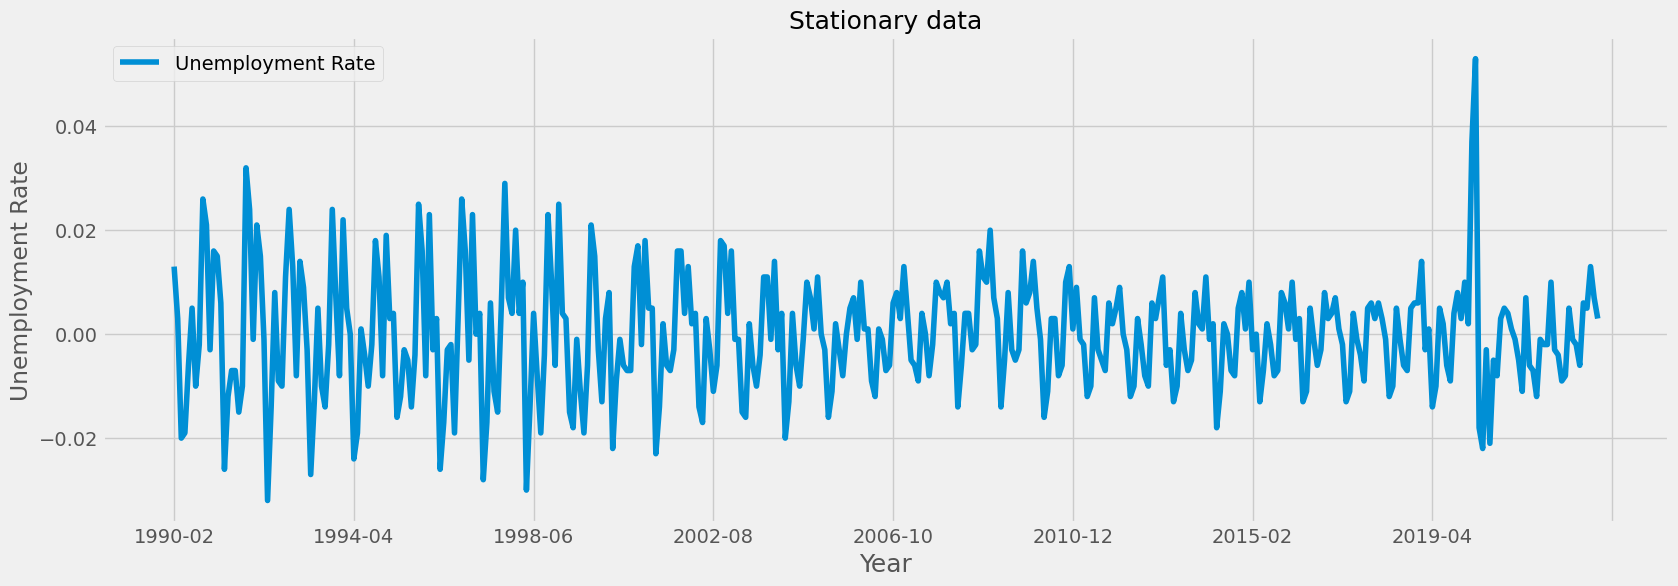

In [10]:
# call our diff() function on Fresno county data to make stationary
Fresno_stationary = diff(Fresno)
Fresno_stationary

In [11]:
Fresno.tail()

,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate
month_year,,,,,
2022-10,Fresno County,454600,428400,26100,0.058
2022-09,Fresno County,456500,432700,23800,0.052
2023-02,Fresno County,466100,427600,38500,0.083
2023-01,Fresno County,458500,423800,34600,0.076
2023-03,Fresno County,467000,427000,40100,0.086


In [12]:
# Drop columns to prep data for time series analysis
Fresno_tsa = Fresno.drop(['Area Name',
             'Labor Force',
             'Employment',
             'Unemployment'], axis =1 )
Fresno_tsa.head()

,Unemployment Rate
month_year,
1990-04,0.122
1990-08,0.092
1990-12,0.134
1990-02,0.139
1990-01,0.126


In [13]:
# replicate stationary data
Fresno_arma = Fresno_tsa.diff(periods =1)

In [14]:
# create cutoff variable for train/test split
cutoff = round(Fresno_arma.shape[0] * 0.75)
cutoff

298

Cell is being used as a holder for the graph function below:

xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))


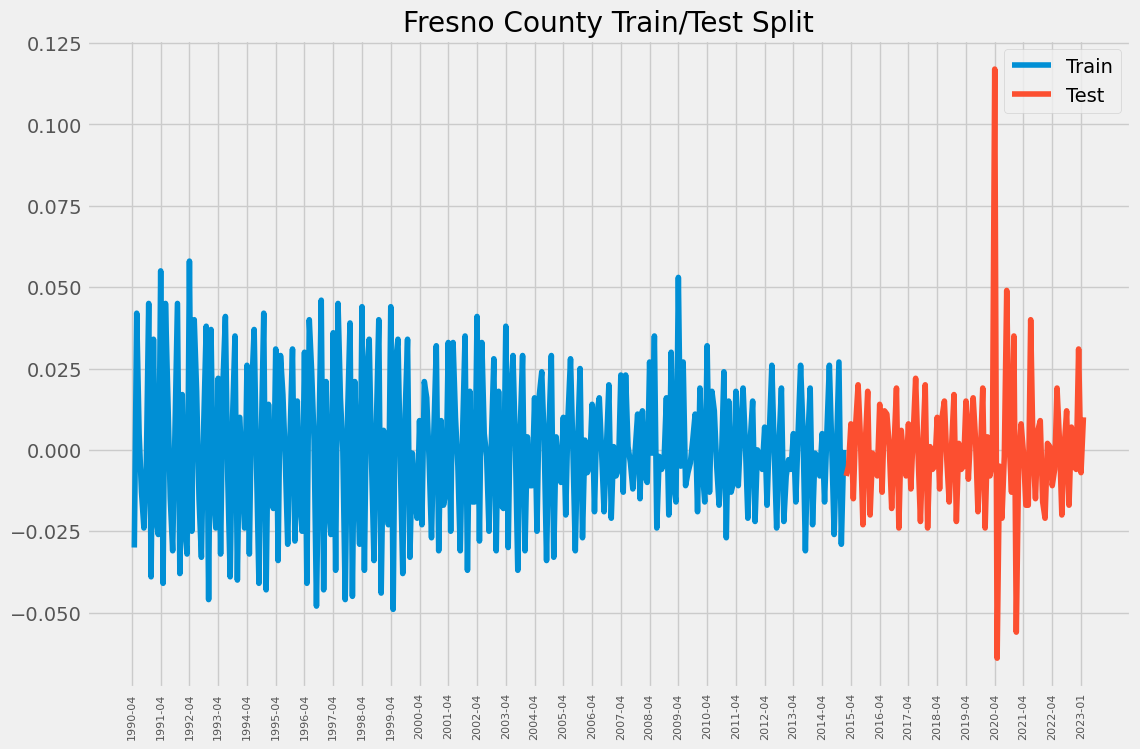

In [15]:
# plot our new split
train = Fresno_arma[:cutoff]
test = Fresno_arma[cutoff: ]

fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Fresno County Train/Test Split')
ax.set_xticks(range(0,len(Fresno_arma), 12))

plt.legend();

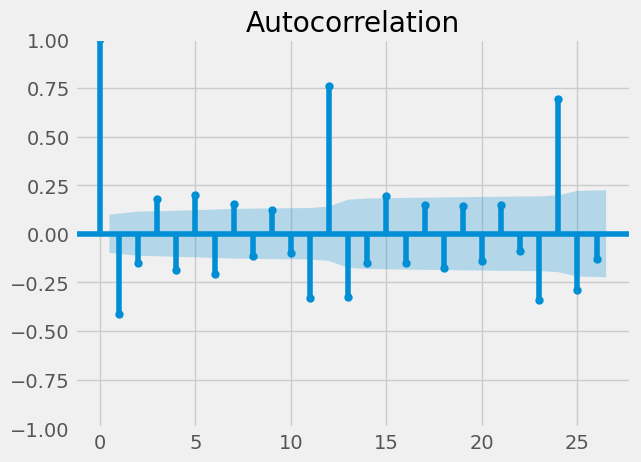

In [16]:
# import acf, pacf and plotting tools
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(Fresno_arma.dropna());

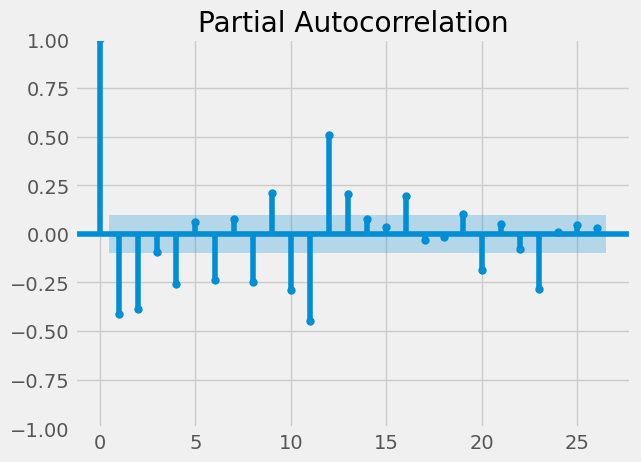

In [17]:
# plot pacf and get our ar term
plot_pacf(Fresno_arma.dropna());

In [18]:
# import ARIMA from statsmodels.tsa.arima.model

# Let's create our baseline model
from statsmodels.tsa.arima.model import ARIMA
arma_Fresno = ARIMA(train, order = (0,0,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [19]:
print(arma_Fresno.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:                          ARIMA   Log Likelihood                 687.520
Date:                Fri, 16 Jun 2023   AIC                          -1371.040
Time:                        19:45:54   BIC                          -1363.645
Sample:                             0   HQIC                         -1368.080
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.204e-05      0.001     -0.030      0.976      -0.003       0.003
sigma2         0.0006   5.99e-05      9.531      0.000       0.000       0.001
Ljung-Box (L1) (Q):                  55.81   Jarque-

In [20]:
train = train.dropna()

In [21]:
y_hat = arma_Fresno.predict(type='levels')
y_hat = y_hat[1:]

In [22]:
# RMSE on our baseline predictor

# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error


np.sqrt(mean_squared_error(train, y_hat))

0.02390135451243794

We will need to figure out how to address acf and pacf. Perhaps a gridsearch function with all of the potential values that could improve our AIC score.

### Gridsearch Function

Thank you to Ely and their __[article](https://medium.com/@ely-lin/grid-searching-time-series-models-1214dfa3de60)__ from medium.com for the two functions below. These function as gridsearch functions and will tell us our best model performance.

In [23]:
def gridsearch(dataset, p_list, d_list, q_list):
    # set initial best AIC score at infinity to start lowering it
    best_aic=float('inf')
    for p in p_list:
        for d in d_list:
            for q in q_list:
                try:
                    # fit the model to this set of parameters
                    model = ARIMA(dataset, order=(p,d,q)).fit()
                    # assign the model's aic attribute to a variable
                    aic = model.aic
                    # compare it to the previous set
                    if aic < best_aic:
                        best_aic=aic
                        best_order = (p,d,q)
                        best_model = model
                except:
                    continue
    return best_aic, best_order, best_model

In [24]:
## Uncomment whole cell to run

## runs gridsearch on train, will take about 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                      [0,6,12,18],
#                                      [1,2,3,4,5,6],
#                                      [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')

## Expected Output: The best AIC score is -1960.1035756349838
## Expected Output: The best order set is (18, 1, 0)

In [25]:
arma_Fresno = ARIMA(train, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [26]:
print(arma_Fresno.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  297
Model:                ARIMA(18, 1, 0)   Log Likelihood                 998.882
Date:                Fri, 16 Jun 2023   AIC                          -1959.763
Time:                        19:46:00   BIC                          -1889.646
Sample:                             0   HQIC                         -1931.690
                                - 297                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3590      0.055    -24.556      0.000      -1.467      -1.251
ar.L2         -1.6687      0.081    -20.526      0.000      -1.828      -1.509
ar.L3         -1.7836      0.115    -15.519      0.0

In [27]:
# Because there is a drift of 1 we will have to drop nulls
train = train.dropna()

In [28]:
# RMSE for our new model
y_hat = arma_Fresno.predict(typ='levels')
np.sqrt(mean_squared_error(train,y_hat))

0.009933621406585177

In [29]:
# fit same ARIMA parameters to  test set
arma_Fresno_test = ARIMA(test, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [30]:
# Get aic score for test score
print(arma_Fresno_test.aic)

-489.2174127815889


In [31]:
# RMSE score for test data
y_hat = arma_Fresno_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.01654086775427879

### Predict Fresno County's incoming unemployment rates

Our prophet model did not perform better than our gridsearch model, we will move forward with the gridsearch model and use that to make some predictions on the next year.

In [32]:
forecast = arma_Fresno.forecast(112)
forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


297    0.000637
298   -0.009120
299    0.005261
300   -0.016623
301    0.006287
         ...   
404   -0.001702
405    0.004765
406   -0.007581
407    0.001918
408   -0.007858
Name: predicted_mean, Length: 112, dtype: float64

In [33]:
forecast.index.tolist()

[297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408]

In [34]:
test.index.tolist()

['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [35]:
forecast = pd.DataFrame(forecast)

In [36]:
forecast.tail()

,predicted_mean
404,-0.001702
405,0.004765
406,-0.007581
407,0.001918
408,-0.007858


In [37]:
list = ['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '2021-11',
 '2021-10',
 '2021-09',
 '2022-04',
 '2022-08',
 '2022-02',
 '2022-01',
 '2022-07',
 '2022-06',
 '2022-03',
 '2022-05',
 '2022-11',
 '2022-10',
 '2022-09',
 '2023-02',
 '2023-01',
 '2023-03',
       '2023-04',
       '2023-05',
       '2023-06',
       '2023-07',
       '2023-08',
       '2023-09',
       '2023-10',
       '2023-11',
       '2023-12',
       '2024-01',
       '2024-02',
       '2024-03'
       ]

forecast['Year'] = list

forecast

,predicted_mean,Year
297,0.000637,2014-10
298,-0.009120,2014-09
299,0.005261,2015-04
300,-0.016623,2015-08
301,0.006287,2015-12
...,...,...
404,-0.001702,2023-11
405,0.004765,2023-12
406,-0.007581,2024-01
407,0.001918,2024-02


In [38]:
forecast = forecast.set_index('Year')

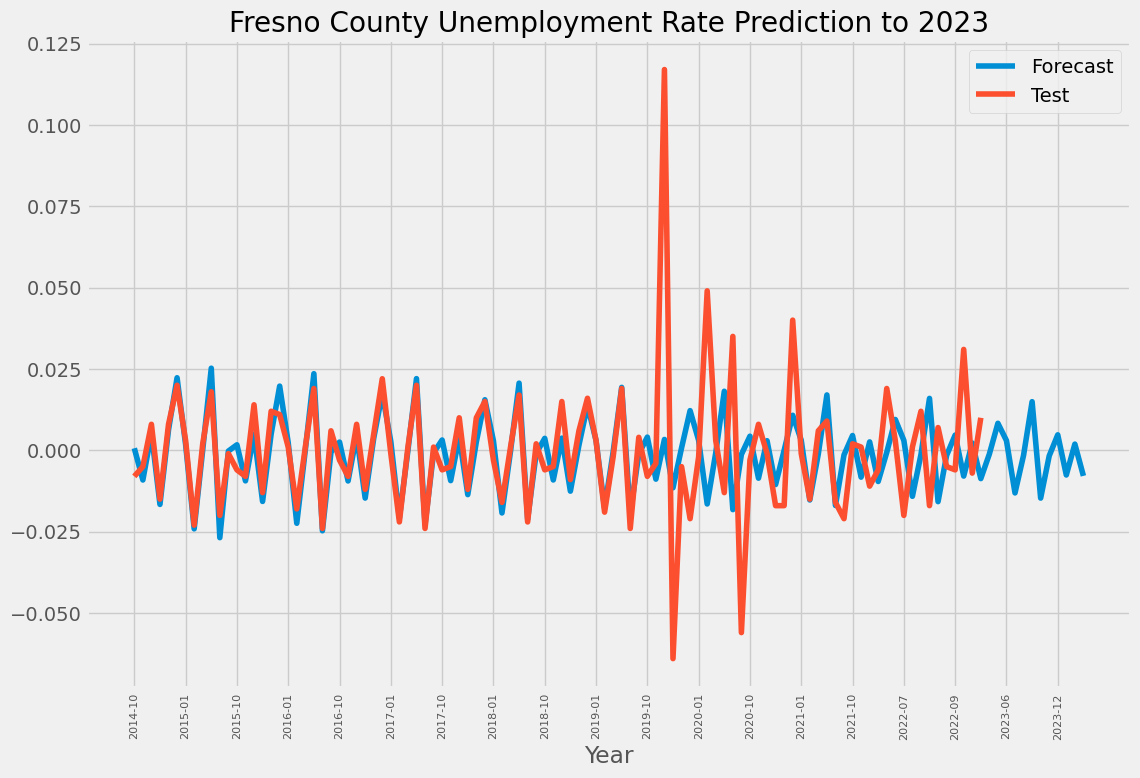

In [39]:
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
# ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('Fresno County Unemployment Rate Prediction to 2023')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(forecast), 6))
ax.legend();

According to our predictive model (set for 12 months from March 2023) we will see a lower rate of unemployment than we have historically.

In [40]:
one_year = forecast.reset_index()
one_year

,Year,predicted_mean
0,2014-10,0.000637
1,2014-09,-0.009120
2,2015-04,0.005261
3,2015-08,-0.016623
4,2015-12,0.006287
...,...,...
107,2023-11,-0.001702
108,2023-12,0.004765
109,2024-01,-0.007581
110,2024-02,0.001918


In [41]:
one_year = one_year[99:112]
one_year

,Year,predicted_mean
99,2023-03,-0.008686
100,2023-04,-0.001151
101,2023-05,0.008308
102,2023-06,0.002999
103,2023-07,-0.013091
104,2023-08,-0.001542
105,2023-09,0.014958
106,2023-10,-0.014682
107,2023-11,-0.001702
108,2023-12,0.004765


In [42]:
one_year = one_year.set_index('Year')

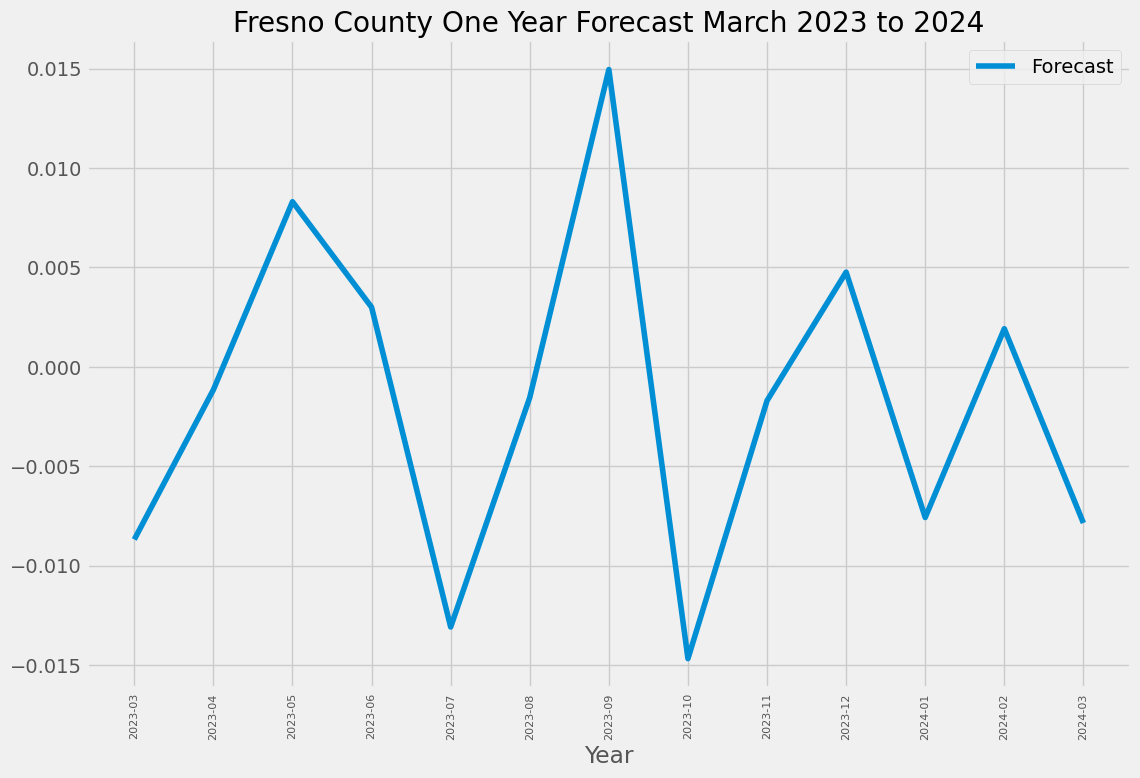

In [43]:
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(one_year, label = 'Forecast')

ax.set_title('Fresno County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(one_year), 1))
ax.legend();

Based on the forecasted dates for Fresno County's rate of unemployment, a potential educational program could be done on a track system, 2 months in school during the months of April - June, 2 months from mid-July - Mid September, and 4  months from mid October to February. While this likely would not be a "one size fits all" program, if flexible instruction were able to be offered during these timesthere could potentially be a wave of trained skilled labor in 1.5 years from Fresno County.

## Function to plot forecast information and one year forecast

In [103]:
# In order to prevent repetetive lines of code here is a function for plotting a one year forecast
def one_year_forecast(one, name):

  # plots test data and forecast data
  fig, ax = plt.subplots(figsize = (12,8))
  plt.xticks(fontsize=8, rotation=90)
  xmin, xmax = ax.get_xlim()
  ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
  ax.plot(one, label = 'Forecast')
  ax.plot(test, label = 'Test')
  ax.set_title(f'{name} County Unemployment Rate Prediction to 2023')
  ax.set_xlabel('Year')
  ax.set_xticks(range(0,len(one), 6))
  ax.legend();


  # plots only forecast data
  one = one.reset_index()

  one = one[99:112]

  one = one.set_index('Year')

  fig, ax = plt.subplots(figsize = (12,8))
  plt.xticks(fontsize=8, rotation=90)
  xmin, xmax = ax.get_xlim()
  ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))

  ax.plot(one, label = 'Forecast')

  ax.set_title(f'{name} County One Year Forecast March 2023 to 2024')
  ax.set_xlabel('Year')
  ax.set_xticks(range(0,len(one), 1))
  ax.legend();


## Effect on Unemployment

The most recent data available regarding __[Fresno County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06019.pdf)__'s ag workforce (2017) puts the total number of workers at 8,206. These are split into: <br>
- 5,554 male workers
- 2,652 female workers
- 556 of which are under the age of 35
- 4,760 between the ages of 35-64
- 2,890 who are 65 or older. <br>

Likely not all candidates would make it through the entire educational program for trade schools, in fact according to __[Graduation Rates at American Trade School](https://www.univstats.com/colleges/american-trade-school/graduation-rate/)__ graduation rates of this specific trade school were slightly above 50% <br>

Let's take a look at the number of actual unemployed and consider that 25% (a rudimentary estimate) of our total seasonally unemployed workers make it through a trade school and are able to be employed in trades. <br>

For the sake of our hypothetical scenario we can consider that 25% of the total population of workers would apply for this program, and if 50% are expected to graduate: <br>

- 2051.5 potential students at a 50% anticipated graduation rate
    - 1025.75 converted students to active trade school grads

In [45]:
fresno = Fresno.sort_index()

Historically, February is the month with the highest level of unemployment. September looks to be the month of highest employment. With this in mind, let's take a look at our dataset's historical numbers; which year was February the highest in unemployment rate and the same for September. We could also just take median and do our research on that year. <br>

Let's take 2017 (the year that we have # of employed ag/migrant workers figures) and base our effect on unemployment analysis on that.

In [46]:
fresno.tail()

,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate
month_year,,,,,
2022-10,Fresno County,454600,428400,26100,0.058
2022-11,Fresno County,457700,428800,29000,0.063
2023-01,Fresno County,458500,423800,34600,0.076
2023-02,Fresno County,466100,427600,38500,0.083
2023-03,Fresno County,467000,427000,40100,0.086


In [47]:
# Our most recent/last entry was 397, March 2023. We are looking for data that is from six years ago (72 months,
# 74 if we start from January)
fresno_2017 = fresno.iloc[324: 336]

In [48]:
fresno_2017

,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate
month_year,,,,,
2017-01,Fresno County,442700,396600,46200,0.104
2017-02,Fresno County,447900,400800,47100,0.105
2017-03,Fresno County,447800,401800,45900,0.103
2017-04,Fresno County,450000,409400,40600,0.090
2017-05,Fresno County,447800,412300,35500,0.079
2017-06,Fresno County,447400,410400,37000,0.083
2017-07,Fresno County,447200,410700,36600,0.082
2017-08,Fresno County,446000,411200,34700,0.078
2017-09,Fresno County,446800,415800,31000,0.069


For 2017, February was the highest level of unemployment with September being the lowest. Our proposed school year for Fresno County would be from October to March with the understanding that a large number of ag/migrant workers will still likely be unemployed/underemployed during this time and would potentially be able to take advantage of educational opportunities as they collect unemployment. <br>

Let's consider that it may take up to two years (6 months to 1 year of full time education to deployment as previously stated) and take a look at the number of potential ag/migrant workers that would be fully employed and the effect it would potentially have on 2019's data.

In [49]:
fresno_2019 = fresno.iloc[348:360]
fresno_2019_ur = fresno_2019.copy()

In [50]:
# labor force would be unaffected in this case as we have not actually introduced any new employable members
fresno_2019['Employment'] = fresno_2019['Employment'].astype(int) + 1025




In [51]:
fresno_2019['Unemployment'] = fresno_2019['Unemployment'].astype(int) - 1025

In [52]:
# Unemployment Rate is unemployment/labor force
fresno_2019['Unemployment Rate'] = fresno_2019['Unemployment'].astype(int)/fresno_2019['Labor Force'].astype(int)

In [53]:
fresno_2019

,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate
month_year,,,,,
2019-01,Fresno County,450500,410525,40075,0.088957
2019-02,Fresno County,452300,413325,38975,0.086171
2019-03,Fresno County,452400,413225,39175,0.086594
2019-04,Fresno County,450500,417525,32875,0.072974
2019-05,Fresno County,453200,424925,28275,0.062390
2019-06,Fresno County,451500,420925,30575,0.067719
2019-07,Fresno County,450300,418925,31375,0.069676
2019-08,Fresno County,450800,422325,28575,0.063387
2019-09,Fresno County,452200,427525,24675,0.054567


In [54]:
fresno_2019_ur

,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate
month_year,,,,,
2019-01,Fresno County,450500,409500,41100,0.091
2019-02,Fresno County,452300,412300,40000,0.088
2019-03,Fresno County,452400,412200,40200,0.089
2019-04,Fresno County,450500,416500,33900,0.075
2019-05,Fresno County,453200,423900,29300,0.065
2019-06,Fresno County,451500,419900,31600,0.070
2019-07,Fresno County,450300,417900,32400,0.072
2019-08,Fresno County,450800,421300,29600,0.066
2019-09,Fresno County,452200,426500,25700,0.057


In [55]:
fresno_2019['Unemployment Rate Change'] = (fresno_2019_ur['Unemployment Rate'] - fresno_2019['Unemployment Rate'])

In [56]:
fresno_2019

,Area Name,Labor Force,Employment,Unemployment,Unemployment Rate,Unemployment Rate Change
month_year,,,,,,
2019-01,Fresno County,450500,410525,40075,0.088957,0.002043
2019-02,Fresno County,452300,413325,38975,0.086171,0.001829
2019-03,Fresno County,452400,413225,39175,0.086594,0.002406
2019-04,Fresno County,450500,417525,32875,0.072974,0.002026
2019-05,Fresno County,453200,424925,28275,0.062390,0.002610
2019-06,Fresno County,451500,420925,30575,0.067719,0.002281
2019-07,Fresno County,450300,418925,31375,0.069676,0.002324
2019-08,Fresno County,450800,422325,28575,0.063387,0.002613
2019-09,Fresno County,452200,427525,24675,0.054567,0.002433


Great, we were able to get a record of the effect on unemployment if our educational program were to be implemented in Fresno County!

### What industries/trades in Fresno County have the largest growth/opportunity?

There appear to be differing opinions on the matter but there is a significant amount of construction work available as Fresno County is still performing work on their high speed rail and construction continues to rise back toward pre-pandemic levels. The educational program that Melissa Montalvo highlights in their article in the Fresno Bee is welding and the construction training program available in Mendota, CA. __['Broken Ladders: Looking for a new job in Fresno? Here’s how you can get free career training'](https://www.fresnobee.com/fresnoland/article261398132.html)__ <br>

<img src = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/pics/mendota-city-municipal-website-by-vortal-website-design-entrance.jpg'>



### Function for effect on unemployment rate

In [57]:
# as a note, you will still need to do all of the preprocessing steps for a given county:
# find ag/migrant employment numbers and consider how many of these workers would be able to
# convert to skilled trade workers, potentially
def effect(county, x): # x serves as our numerical value placeholder

    # insurance that our index is sorted based on actual time series
    county = county.sort_index()
    # slice dataframe to only include 2019's data
    county_2019 = county.iloc[348:360]
    # create new variable copy
    county_2019_ur = county_2019.copy()
    # simple math for employment numbers, x is an input from our previous preprocessing steps
    county_2019['Employment'] = county_2019['Employment'].astype(int) + x
    # simple math for unemployment
    county_2019['Unemployment'] = county_2019['Unemployment'].astype(int) - x
    # divide unemployment by labor force to get our new unemployment rate
    county_2019['Unemployment Rate'] = county_2019['Unemployment'].astype(int)/county_2019['Labor Force']
    # create new column 'Unemployment Rate Change' to show rate of unemployment change
    county_2019['Unemployment Rate Change'] = (county_2019_ur['Unemployment Rate'] - county_2019['Unemployment Rate'])
    # return 2019 data
    return county_2019

### FB Prophet: Fresno

Let's try Facebook's Prophet model to see if we can create a better performant model than our Gridsearch Function.

In [58]:
import prophet
# import tools for prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [59]:
# Call on original 'Fresno' variable and reset_index()
fresno = Fresno.copy()
Fresno = Fresno.reset_index()

In [60]:
Fresno = Fresno.drop(['Area Name', 'Labor Force', 'Employment',
             'Unemployment'], axis =1)

In [61]:
Fresno.head()

,month_year,Unemployment Rate
0,1990-04,0.122
1,1990-08,0.092
2,1990-12,0.134
3,1990-02,0.139
4,1990-01,0.126


In [62]:
# Based on documentation, column names are hard coded as 'ds' and 'y'
Fresno.columns = ['ds', 'y']

In [63]:
Fresno['ds'] = pd.to_datetime(Fresno['ds'])
Fresno.tail()

,ds,y
393,2022-10-01,0.058
394,2022-09-01,0.052
395,2023-02-01,0.083
396,2023-01-01,0.076
397,2023-03-01,0.086


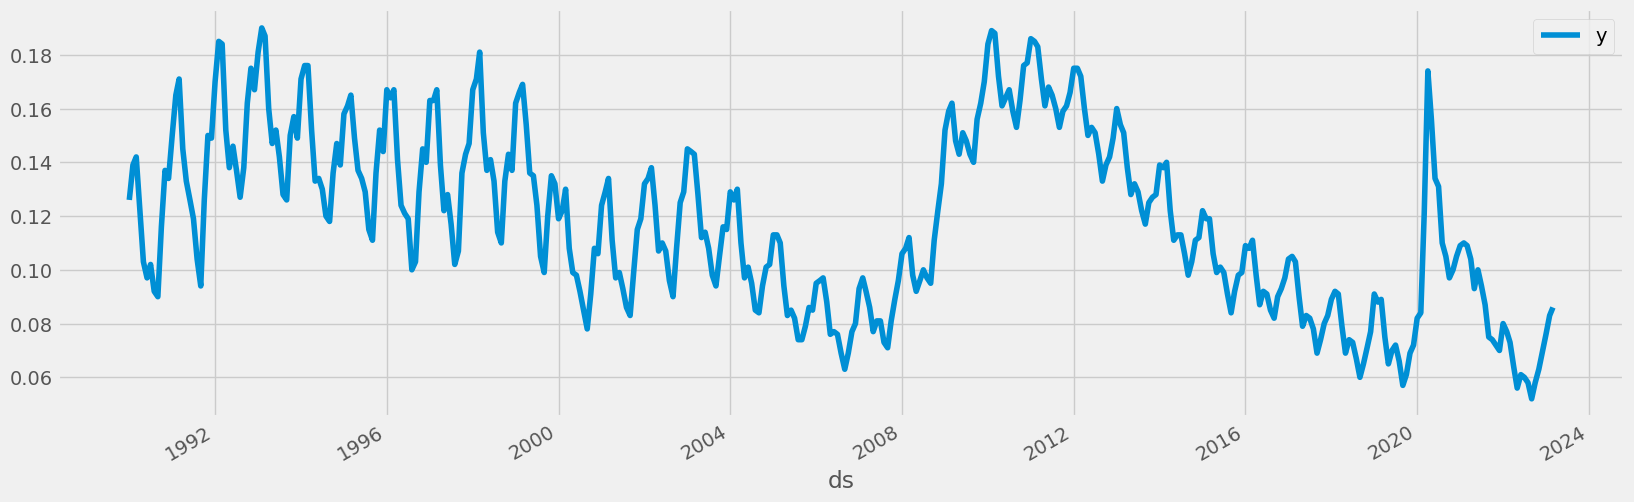

In [64]:
# plot data, should look fairly familiar
Fresno.plot(x='ds', y='y', figsize = (18,6));

In [65]:
len(Fresno)

398

In [66]:
# call same cutoff block as before
cutoff = round(Fresno.shape[0] * 0.75)

    # plot our new split
train = Fresno[:cutoff]
test = Fresno[cutoff: ]

In [67]:
# fit our prophet onto our training set and make some predictions,
# for now we will just make predictions onto full test set to
# test score and get RMSE for test set
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods = 100, freq = 'M')
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdi5t_bb7/n4cnh8q1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdi5t_bb7/hst64si4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7457', 'data', 'file=/tmp/tmpdi5t_bb7/n4cnh8q1.json', 'init=/tmp/tmpdi5t_bb7/hst64si4.json', 'output', 'file=/tmp/tmpdi5t_bb7/prophet_modelxdwj2p01/prophet_model-20230616194610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [68]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
393,2022-11-30,0.198041,0.174811,0.229099,0.189180,0.208149,0.003870,0.003870,0.003870,0.003870,0.003870,0.003870,0.0,0.0,0.0,0.201911
394,2022-12-31,0.198503,0.188383,0.244973,0.189490,0.208852,0.017927,0.017927,0.017927,0.017927,0.017927,0.017927,0.0,0.0,0.0,0.216430
395,2023-01-31,0.198966,0.192420,0.246891,0.189812,0.209525,0.019817,0.019817,0.019817,0.019817,0.019817,0.019817,0.0,0.0,0.0,0.218783
396,2023-02-28,0.199384,0.196907,0.253535,0.190109,0.210051,0.024137,0.024137,0.024137,0.024137,0.024137,0.024137,0.0,0.0,0.0,0.223521
397,2023-03-31,0.199846,0.178122,0.235989,0.190463,0.210702,0.007039,0.007039,0.007039,0.007039,0.007039,0.007039,0.0,0.0,0.0,0.206885


In [69]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
393,2022-11-30,0.201911,0.174811,0.229099
394,2022-12-31,0.216430,0.188383,0.244973
395,2023-01-31,0.218783,0.192420,0.246891
396,2023-02-28,0.223521,0.196907,0.253535
397,2023-03-31,0.206885,0.178122,0.235989


In [70]:
test.tail()

,ds,y
393,2022-10-01,0.058
394,2022-09-01,0.052
395,2023-02-01,0.083
396,2023-01-01,0.076
397,2023-03-01,0.086


In [71]:
# plot our sexy prophet model
plot_plotly(m, forecast)

In [72]:
from statsmodels.tools.eval_measures import rmse

In [73]:
predictions = forecast.iloc[cutoff:]['yhat']

In [74]:
# Settle the bet, is this a better performant model than the previous one?
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())


Root Mean Squared Error between actual and  predicted values:  0.09581784993317125
Mean Value of Test Dataset: 0.08828


Though prophet was not able to create a better performant model than our gridsearch function, let's create a function that completes the steps from our prophet model.

## FB Prophet Function

In [75]:
# function to return graph of county's historical unemployment rate and baseline prophet model along with RMSE score
def prophet(county):

    county = county.reset_index()

    county = county.drop(['Area Name', 'Labor Force', 'Employment',
             'Unemployment'], axis =1)

    county.columns = ['ds', 'y']

    county['ds'] = pd.to_datetime(county['ds'])



    cutoff = round(county.shape[0] * 0.75)

    train = county[:cutoff]
    test = county[cutoff: ]

    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = 100, freq ='M')
    forecast = m.predict(future)

    county.plot(x = 'ds', y = 'y', figsize = (18,6))
    predictions = forecast.iloc[cutoff:]['yhat']
    print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
    print("Mean Value of Test Dataset:", test['y'].mean())
    return plot_plotly(m, forecast)
    return




In [76]:
# function to return graph of county's historical unemployment rate and baseline prophet model along with RMSE score
def prophet_unemployment(county):

    county = county.reset_index()

    county = county.drop(['Area Name', 'Labor Force', 'Employment',
             'Unemployment Rate'], axis =1)

    county.columns = ['ds', 'y']

    county['ds'] = pd.to_datetime(county['ds'])



    cutoff = round(county.shape[0] * 0.75)

    train = county[:cutoff]
    test = county[cutoff: ]

    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = 100, freq ='M')
    forecast = m.predict(future)

    county.plot(x = 'ds', y = 'y', figsize = (18,6))
    predictions = forecast.iloc[cutoff:]['yhat']
    print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
    print("Mean Value of Test Dataset:", test['y'].mean())
    return plot_plotly(m, forecast)
    return




## Function for Recurrent Neural Network

In [77]:
# function for RNN
def RNN(county):

  # make index into datetime
  county.index = pd.to_datetime(county.index)

  # sort index
  county = county.sort_index()

  # drop unnecessary columns from county
  county = county.drop(['Area Name',
                        'Labor Force',
                        'Employment',
                        'Unemployment'], axis =1)

  # create cutoff variable for train/test split
  cutoff = round(county.shape[0] * 0.75)
  cutoff

  # create train/test split
  train = county[:cutoff]
  test = county[cutoff:]

  # call on MinMaxScaler, set on variable scaler
  scaler = MinMaxScaler()

  # fit scaler onto training data
  scaler.fit(train)
  scaled_train = scaler.transform(train)
  scaled_test = scaler.transform(test)

  # predict 12 months into the future
  n_input = 12
  generator = TimeseriesGenerator(scaled_train,
                                  scaled_train,
                                  length = n_input,
                                  batch_size =1)

  # define our model
  model = Sequential()
  model.add(LSTM(100, activation = 'linear', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # fit model onto generator
  model.fit(generator, epochs = 50)

  loss_per_epoch = model.history.history['loss']
  plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

  test_predictions = []

  first_eval_batch = scaled_train[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(len(test)):

    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

  true_predictions = scaler.inverse_transform(test_predictions)

  # plot our model predictions against actual for final 12 months of data available
  test['Predictions'] = true_predictions
  test.plot(figsize=(14,5));

  # get rmse
  rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
  print(rmse)




## __[Monterey County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06053.pdf)__ Stationary Data

Test Statistic                -6.080526e+00
p-value                        1.094995e-07
#Lags Used                     1.100000e+01
Number of Observations Used    3.850000e+02
Critical Value (1%)           -3.447450e+00
Critical Value (5%)           -2.869077e+00
Critical Value (10%)          -2.570785e+00
dtype: float64

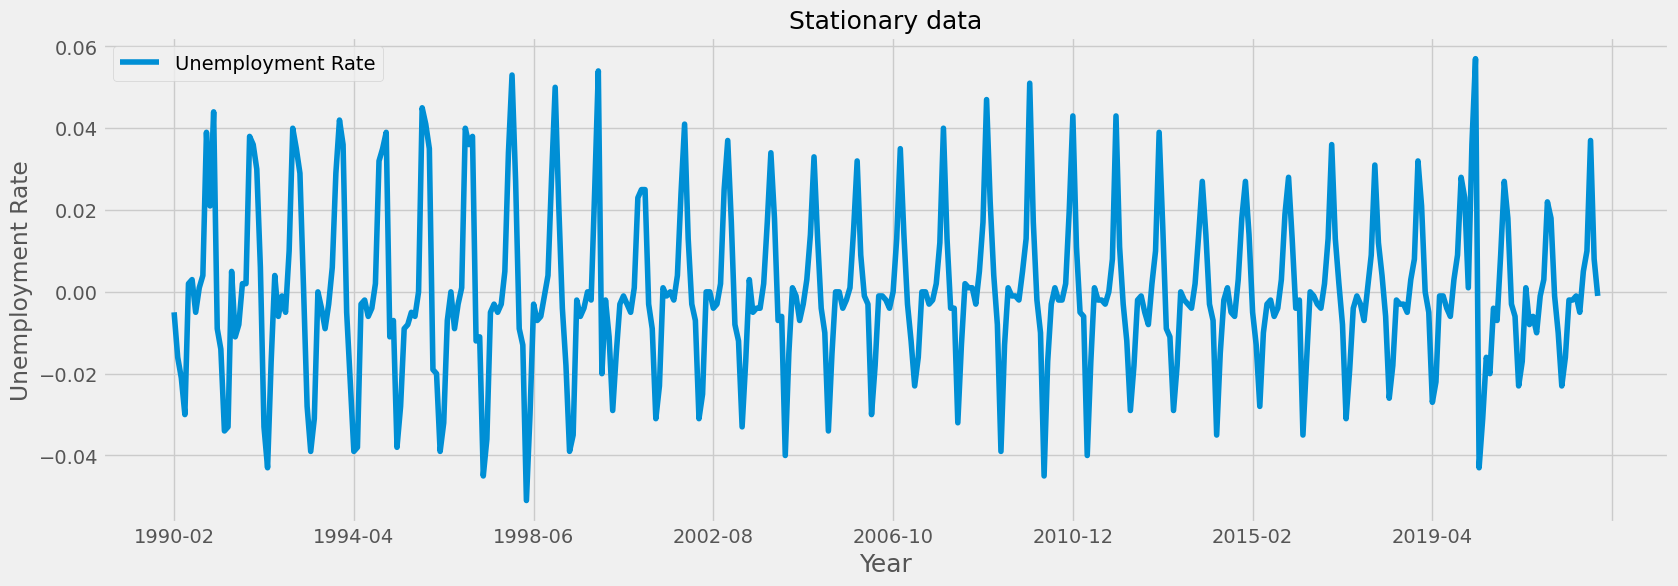

In [78]:
# call our diff() function on Monterey county data to make stationary
Monterey_stationary = diff(Monterey)
Monterey_stationary

In [79]:
county = Monterey.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

### Gridsearch Function Monterey County

In [80]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -1919.760684917757
# # Expected output: The best order set is (18, 1, 0)

In [81]:
arma_Monterey = ARIMA(train, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [82]:
print(arma_Monterey.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:                ARIMA(18, 1, 0)   Log Likelihood                 978.771
Date:                Fri, 16 Jun 2023   AIC                          -1919.543
Time:                        19:46:22   BIC                          -1849.362
Sample:                             0   HQIC                         -1891.447
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4586      0.053    -27.753      0.000      -1.562      -1.356
ar.L2         -1.8764      0.085    -21.992      0.000      -2.044      -1.709
ar.L3         -2.1090      0.112    -18.875      0.0

In [83]:
train = train.dropna()

In [84]:
y_hat = arma_Monterey.predict(typ='levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

0.0118738401406874

In [85]:
arma_Monterey_test = ARIMA(test, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [86]:
print(arma_Monterey_test.aic)

-411.6272198487386


In [87]:
y_hat = arma_Monterey_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.024879676983736013

### Predict Monterey County's incoming unemployment rates

In [88]:
forecast = arma_Monterey.forecast(112)
forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



298   -0.013588
299   -0.003549
300    0.011201
301   -0.020322
302    0.041702
         ...   
405    0.002074
406   -0.009271
407   -0.003647
408    0.003427
409   -0.012796
Name: predicted_mean, Length: 112, dtype: float64

In [89]:
forecast.index.tolist()

[298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409]

In [90]:
test.index.tolist()

['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [91]:
stop

NameError: ignored

In [97]:
# Create new variable name to use fully capitalized variable name in one_year_forecast function as title
MONTEREY = pd.DataFrame(forecast)

In [98]:
MONTEREY['Year'] = list
MONTEREY

,predicted_mean,Year
298,-0.013588,2014-10
299,-0.003549,2014-09
300,0.011201,2015-04
301,-0.020322,2015-08
302,0.041702,2015-12
...,...,...
405,0.002074,2023-11
406,-0.009271,2023-12
407,-0.003647,2024-01
408,0.003427,2024-02


In [99]:
MONTEREY = MONTEREY.set_index('Year')

In [100]:
MONTEREY

,predicted_mean
Year,
2014-10,-0.013588
2014-09,-0.003549
2015-04,0.011201
2015-08,-0.020322
2015-12,0.041702
...,...
2023-11,0.002074
2023-12,-0.009271
2024-01,-0.003647


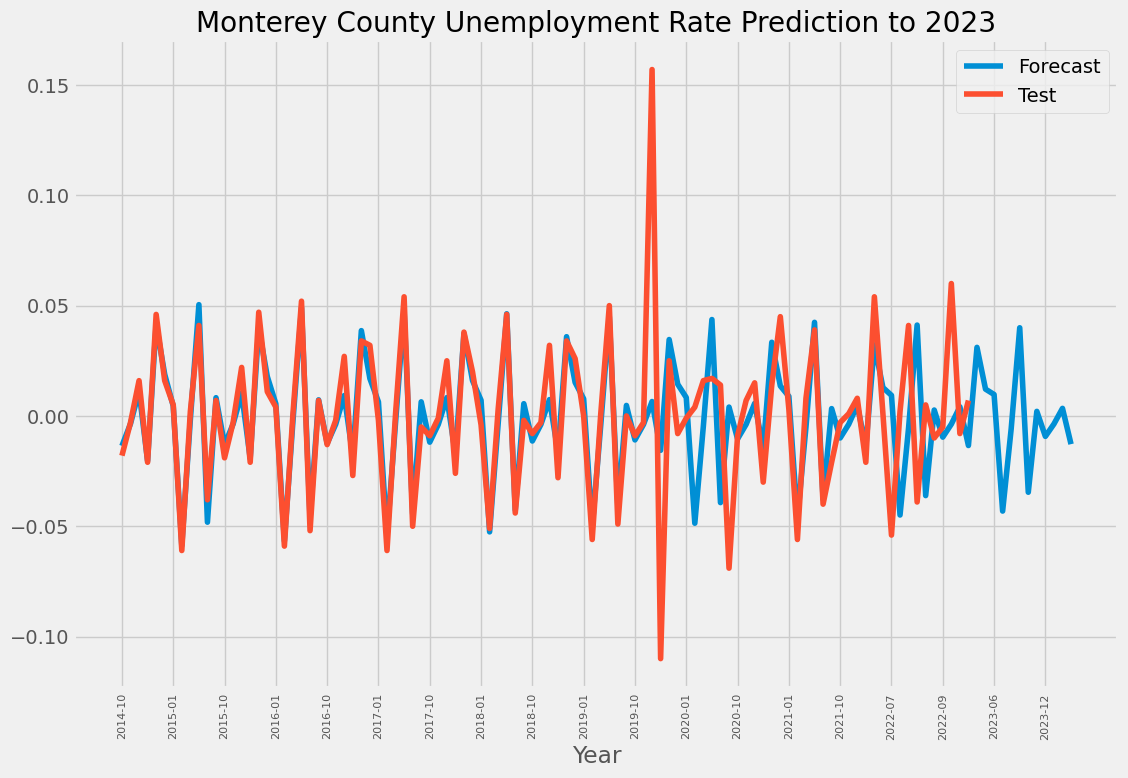

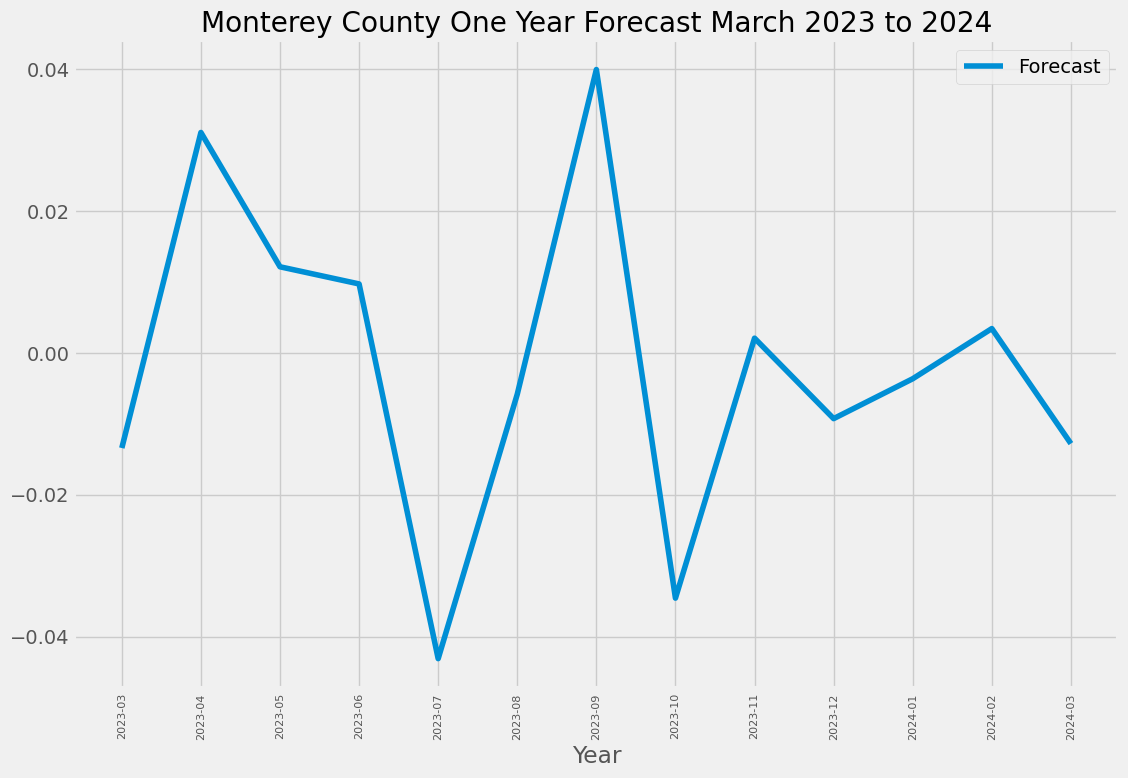

In [104]:
one_year_forecast(MONTEREY, 'Monterey')

### FB Prophet: Monterey

In [ ]:
prophet(Monterey)

Unfortunately Prophet does not provide us with a more powerful model.

### Effect on Unemployment Rate: Monterey County

According to our data on __[Monterey County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06053.pdf)__'s ag worker data, there are: <br>

- 1,356 male workers
- 588 female workers
- 175 of which are under the age of 35
- 1174 between the ages of 35-64
- 595 above the age of 65 <br>
- total 1,944 workers

Again, with consideration that not all of the workforce will take this educational opportunity, we will use the same parameters as on Fresno county's agriculture workforce. <br>

So again, with 1,944 total ag workers, with an anticipated 25% taking advantage of an educational opportunity, and a 50% anticipated graduation rate we would have: <br>

- 243 new skilled trade workers in 2019

In [ ]:
effect(Monterey, 243)

According to a recent article from _Monterey County Weekly_ in their article __[Housing and labor shortages are holding back the Monterey Bay region’s economy](https://www.montereycountyweekly.com/blogs/news_blog/housing-and-labor-shortages-are-holding-back-the-monterey-bay-region-s-economy/article_2b1542f2-fb81-11ed-8042-47ed37dd3160.html)__ published May 25, 2023, the largest growing sector currently is manufacturing but according to Christopher Thornberg of Beacon Economics, at the MBEP’s (Monterey Bay Economic Partnership) 2023 Regional Economic Outlook virtual event, the current housing crisis in Monterey County is not based in unaffordable housing, it is due to lack of housing. <br>

Rey Mashayekhi, the author of the article outlines Thornberg's sentiments, that
<br>
"The “real worries,” he noted, should be around housing shortages impacting workers in places like California, which are contributing to the “enormous issue” of labor shortages that are hurting businesses. That’s led to California’s declining population and lower net migration pattern in recent years, which have affected the Monterey Bay region’s economy."<br>

It is suggested that potential candidates take advantage of drywall, plumbing, hvac, or electrical schooling in the Monterey County area.<br>

<img src = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/pics/MCH-L-HOUSING-1201.webp'>
<p style="text-align: center;">Housing construction in Monterey County from the Monterey Herald</p>

## __[Kern County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06029.pdf)__ Stationary Data

In [ ]:
Kern_stationary = diff(Kern)
Kern_stationary

In [ ]:
county = Kern.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

### Gridsearch Function Kern County

In [ ]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -1926.5166750777462
# # Expected output: The best order set is (12, 1, 18)

In [ ]:
arma_Kern = ARIMA(train, order = (12,1,18)).fit()

In [ ]:
print(arma_Kern.summary())

In [ ]:
train = train.dropna()

In [ ]:
y_hat = arma_Kern.predict(typ = 'levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

In [ ]:
arma_Kern_test = ARIMA(test, order = (12,1,18)).fit()

In [ ]:
print(arma_Kern_test.aic)

In [ ]:
y_hat = arma_Kern_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

### Predict Kern County's incoming unemployment rates

In [ ]:
forecast = arma_Kern.forecast(112)
forecast.index.tolist()
test.index.tolist()

In [ ]:
forecast = pd.DataFrame(forecast)
forecast.tail()

In [ ]:
forecast['Year'] = list
forecast = forecast.set_index('Year')

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
# ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')

ax.set_title('Kern County Prediction to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(forecast), 6))
ax.legend();

### FB Prophet: Kern County

In [ ]:
prophet(Kern)

### Effect on Unemployment Rate: Kern County

__[Kern County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06029.pdf)__'s ag worker data shows that in 2017 there were: <br>

- 2,162 male workers
- 997 female workers
- 230 under the age of 35
- 1,820 between the ages of 35-64
- 1,109 over the age of 65
- in total there are 3,159 workers in Kern County <br>

We anticipate that somewhere around 394 workers would become skilled trade workers in 2019.


In [ ]:
effect(Kern, 394)

According to the __[Kern County Economic Forecast](https://dot.ca.gov/-/media/dot-media/programs/transportation-planning/documents/data-analytics-services/transportation-economics/socioeconomic-forecasts/2021/2021-pdf/kern-profile-a11y.pdf)__, published in 2021, "Construction saw a relatively large decline" but was anticipated to have "a full recovery ... expected in 2023 or 2024."

## __[Tulare County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06107.pdf)__ Stationary Data

In [ ]:
Tulare_stationary = diff(Tulare)
Tulare_stationary

In [ ]:
county = Tulare.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

### Gridsearch Function Tulare County

In [ ]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -1708.1863069146839
# # Expected output: The best order set is (18, 1, 18)

In [ ]:
arma_Tulare = ARIMA(train, order = (18,1,18)).fit()

In [ ]:
print(arma_Tulare.summary())

In [ ]:
train = train.dropna()

In [ ]:
y_hat = arma_Tulare.predict(typ='levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

In [ ]:
arma_Tulare_test = ARIMA(test, order= (18,1,18)).fit()

In [ ]:
print(arma_Tulare_test.aic)

In [ ]:
y_hat = arma_Tulare_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

### Predict Tulare County's incoming unemployment rates

In [ ]:
forecast = arma_Tulare.forecast(112)
forecast.index.tolist()
test.index.tolist()

In [ ]:
forecast = pd.DataFrame(forecast)

In [ ]:
forecast['Year'] = list
forecast

In [ ]:
forecast = forecast.set_index('Year')

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
# ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')

ax.set_title('Tulare County Prediction to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(forecast), 6))
ax.legend();

### FB Prophet: Tulare County

In [ ]:
prophet(Tulare)

### Effect on Unemployment Rate: Tulare County

__[Tulare County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06107.pdf)__ has a total of 7,163 ag workers, with an anticipated 895 that would apply and graduate from an educational program.

In [ ]:
effect(Tulare, 895)

Reggie Ellis wrote a piece on __[Chris Thornberg's presentation to Tulare County officials in 2022](https://thesungazette.com/article/news/2022/02/22/economist-chris-thornberg-tells-tulare-county-to-focus-on-workers-workers-workers/)__, Ellis outlines Thornberg's presentation on the labor shortage as a shortage of amenities, affordable homes for families, and lack of workforce. This would seem paradoxical, as Thornburg explains, "There is not enough housing for people to live in this state," and that "if you don't build them, people aren't going to come." <br>

There appears to be a clear push for construction work to be done in the Central Valley.

<img src='https://github.com/joshstruggles/Local-Area-Unemployment-Statistics-California/blob/main/pics/2-18_re-summit_chris-thornberg-labor-market-1.jpg?raw=1'>
<center>Chris Thornberg of Beacon Economics giving a presentation to Tulare County officials in 2022 on the labor shortage</center>

## __[San Joaquin County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06077.pdf)__ Stationary Data

In [ ]:
San_Joaquin_stationary = diff(San_Joaquin)
San_Joaquin_stationary

In [ ]:
county = San_Joaquin.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

In [ ]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -2030.3340755639715
# # Expected output: The best order set is (18, 1, 0)

In [ ]:
arma_SJ = ARIMA(train, order = (18,1,0)).fit()

In [ ]:
print(arma_SJ.summary())

In [ ]:
train = train.dropna()

In [ ]:
y_hat = arma_SJ.predict(typ='levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

In [ ]:
arma_SJ_test = ARIMA(test, order = (18,1,0)).fit()

In [ ]:
print(arma_SJ_test.aic)

In [ ]:
y_hat = arma_SJ_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

### Predict San Joaquin County's incoming unemployment rates

In [ ]:
forecast = arma_SJ.forecast(112)
forecast.index.tolist()
test.index.tolist()

In [ ]:
forecast = pd.DataFrame(forecast)

In [ ]:
forecast['Year'] = list
forecast

In [ ]:
forecast = forecast.set_index('Year')

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
# ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')

ax.set_title('San Joaquin County Prediction to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(forecast), 6))
ax.legend();

### FB Prophet: San Joaquin County

In [ ]:
prophet(San_Joaquin)

### Effect on Unemployment Rate:  __[San Joaquin County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06077.pdf)__

Of the 6,176 total ag/migrant workers in San Joaquin County we anticipate that 772 workers would graduate from a trade school given the opportunity.

In [ ]:
effect(San_Joaquin, 772)

According to the EDD, there is a list of the top 5 __[In-Demand Middle-Skill Occupations](https://edd.ca.gov/siteassets/files/jobs_and_training/pubs/carrerladder_sanjoaquinvalley.pdf)__ for the entire San Joaquin Valley Region (Fresno, Inyo, Kern, Kings, Madera, Merced, Mono, San Joaquin, Stanislaus, and Tulare counties), the first of which is a Heavy and Tractor-Trailer Trucker Driver. Heavy equipment driving is not what is considered skilled trade work, but there is an eduational component involved and is skilled work, non-union represented. <br>

### Limitations of the data and information available

The greatest limitation of data available is the number of actual migrant workers currently in employ in California. The figures that we were able to find were from 2017; this may be smaller or larger in 2023 and could affect the analysis of our potential pool of workers. This could also affect labor pool, employed, unemployed, and unemployment rate numbers.

# Concluding Remarks

Based on the business problem I believe that we have successfully identified a group of workers inside California that would be considered capable of filling the skilled labor gap present in our communities. <br>

The groups of workers in question is ag/migrant workers and though they are critical to the infrastructure and supply of food not only for California, but for the world (California is the fourth largest supplier of crops in the world), Chris Thornberg in his __[presentation to Tulare County officials](https://thesungazette.com/article/news/2022/02/22/economist-chris-thornberg-tells-tulare-county-to-focus-on-workers-workers-workers/)__ stated that there are only three ways to increase the workforce in a region: <br>

- Extensive: increasing labor force through immigration (SR) or birthrates (LR)
- Intensive: raising participation rates among the existing population
- Productivity enhancements: capital investments/ skill training<br>

We have suggested in some part, all three of these measures: <br>

- Extensive: migrant workers support the largest economy in the central valley of California but suffer the largest inequities in regards to pay, shelter, and opportunity for growth; disruption of that business model in the form of an educational program like the one suggested would inevitably shake up the structure of the current and afford more opportunity to incoming migrant workers thus filling the gaps in the laborforce while forcing __[conditions](https://calmatters.org/california-divide/2023/02/farmworkers-conditions-california-report/)__ to improve based on competition with an educational program that would afford migrant workers opportunities to further their upward mobility in America.
- Intensive: migrant workers already live and exist in the central valley of California and suffer from unemployment due to the seasonal nature of their work. Though they are supported by a union and are given the ability to look for work during their times of unemployment, there is no built in educational program that might afford migrant workers the ability to find work.
- Productivity enhancements: skilled labor would be considered a form of skill training; the beauty of skilled labor is that oftentimes once an apprenticeship has begun there are opportunities to be paid for work and at higher rates than what is offered to migrant and seasonal farm workers.

## Forecasting with RNN (__[Recurrent Neural Networks](https://towardsdatascience.com/temporal-loops-intro-to-recurrent-neural-networks-for-time-series-forecasting-in-python-b0398963dc1f#:~:text=Recurrent%20Neural%20Networks%3A%20The%20Concept,data%20such%20as%20time%20series.)__)

RNN's are deep learning models, typically used to solve problems with sequential input data such as time series. RNN's are a type of neural network that retains a memory of what it has already processed and thus can learn from previous iterations during its training. Majority of code is taken from walkthrough by __[Nachiketa Hebbar](https://www.youtube.com/watch?v=S8tpSG6Q2H0)__

In [ ]:
stop

In [ ]:
fresno.index = pd.to_datetime(fresno.index)

In [ ]:
fresno = fresno.sort_index()

In [ ]:
# For the sake of this exercise let's try using whole percentages
fresno['Unemployment Rate'] *= 100

In [ ]:
# let's try this out on the fresno dataset
# import seasonal_decompose from statsmodels.tsa.seasonal
# from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# plt.style.use('ggplot')
# plt.style.use('classic')

In [ ]:
# results = seasonal_decompose(fresno['Unemployment Rate'], period =1)
# results.plot();

Nothing too impressive going on with our seasonal_decompose. Let's move on.

In [ ]:
# let's remind ourselves how long this dataset is.

len(fresno)

In [ ]:
fresno.head()

In [ ]:
fresno = fresno.drop(['Area Name',
             'Labor Force',
             'Employment',
             'Unemployment'], axis =1)

In [ ]:
# Let's use the same train/test split from earlier in the notebook
cutoff = round(fresno.shape[0] * 0.75)
cutoff

train = fresno[:cutoff]
test = fresno[cutoff:]

In [ ]:
# part of the reason that we wanted to look at percentage as
# whole numbers was to make the job of MinMaxScaler a bit
# more effective
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
# define generator

n_input = 3
n_features = 1

generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

In [ ]:
X.shape

In [ ]:
# Let's do the same thing but for one year
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [ ]:
# define our model
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
# fit model onto generator
model.fit(generator, epochs=50)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

Great! 50 epochs might have been a bit overkill. Looks like 30 maybe would have been sufficient.

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test[0]

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

In [ ]:
test_predictions

In [ ]:
test.tail()

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [ ]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

This is significantly worse than the performance we got from our gridsearch ARIMA models, but let's see if we can improve the performance by placing a similar gridsearch function onto our RNN model.

## Improving RNN Performance

Though not necessary under every circumstance, let's see if we get a lower RMSE (therefore more accurate) score on a stationary model.

In [ ]:
# make stationary data out of our fresno dataset
county = fresno.diff(periods =1)
county.head()

In [ ]:
# Drop null values
county = county.dropna()

In [ ]:
cutoff = round(county.shape[0] *0.75)
cutoff

train = county[:cutoff]
test = county[cutoff: ]

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
model.fit(generator, epochs = 50)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test[0]

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

In [ ]:
test_predictions

In [ ]:
test.tail()

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

Visually this is a huge improvement. Let's see what our RMSE score is.

In [ ]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

In terms of accuracy this is a significant improvement, however our ARIMA model with gridsearch is still a better performant model.

### Further improvements

Let's try using a smaller test set.

In [ ]:
index_show = county.reset_index()
index_show

In [ ]:
# We used data from 2014 previously, let's try just using one year for our test set
train = county[:384]
test = county[384:]

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [ ]:
# define our model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
model.fit(generator, epochs = 50)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

In [ ]:
test_predictions

In [ ]:
test.tail()

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [ ]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

It looks like the performance from our ARIMA gridsearch model was the best performant. Let's utilize that set of data for our analysis.

In [ ]:
# RNN(Monterey)

In [ ]:
# RNN(Kern)

In [ ]:
# RNN(Tulare)

In [ ]:
# RNN(San_Joaquin)